In [1]:
## Prepare the environment

In [13]:
import os

In [8]:
!ls ../scripts

create_cluster_kind.sh			  minio-k8s.yaml
create_deploy_collect_info.sh		  mycluster_base.yaml
g5k_prepare_openwhisk_cluster.py	  mycluster.yaml
kind-cluster.yaml			  prepare_openwhisk_cluster.py
kubernetes_event_exporter_deployment.yml  scheduler.json
local					  set_up_openwhisk.sh
metrics-server-original.yaml		  upload_files_to_minio.sh
metrics-server.yaml


In [10]:
!python3 ../scripts/prepare_openwhisk_cluster.py

ERROR: failed to create cluster: error reading file: open ./kind-cluster.yaml: no such file or directory
error: 'openwhisk-role' already has a value (core), and --overwrite is false
error: 'openwhisk-role' already has a value (invoker), and --overwrite is false
error: 'openwhisk-role' already has a value (invoker), and --overwrite is false
helm repo add openwhisk https://openwhisk.apache.org/charts
"openwhisk" already exists with the same configuration, skipping
helm repo update
Hang tight while we grab the latest from your chart repositories...
...Successfully got an update from the "fluent" chart repository
...Successfully got an update from the "grafana" chart repository
...Successfully got an update from the "openwhisk" chart repository
...Successfully got an update from the "prometheus-community" chart repository
Update Complete. ⎈Happy Helming!⎈
helm install owdev openwhisk/openwhisk -n openwhisk --create-namespace -f ./mycluster.yaml
Error: cannot re-use a name that is still in 

In [ ]:
## Run the experiments the environment

In [ ]:
## To modify the experiment, modify the exp_description.yaml

In [11]:
!cat exp_description.yaml

exp: 
  - phase: create
    args:
      - i
    actions:
    
    - name: floatoperation1
      source: ../functions/float_operation/function.py
    - name: floatoperation2
      source: ../functions/float_operation/function.py

    - name: linpack1
      source: ../functions/linpack/function.py
      docker_image: andersonandrei/python3action:linpack
    - name: linpack2
      source: ../functions/linpack/function.py
      docker_image: andersonandrei/python3action:linpack

    - name: imageprocessing1
      source: ../functions/image_processing/function.py
      docker_image: andersonandrei/python3action:image_processing
    - name: imageprocessing2
      source: ../functions/image_processing/function.py
      docker_image: andersonandrei/python3action:image_processing

    - name: modeltraining1
      source: ../functions/model_training/function.py
      docker_image: andersonandrei/python3action:model_training
    - name: modeltraining2
      source: ../functions/model_training/fun

In [14]:
exp_tag = "exp16"
os.system('mkdir results/'+ exp_tag)

0

In [ ]:
!python3 run_experiments.py

In [ ]:
!python3 analysis/log_analysis.py

In [17]:
os.system('cp analysis/activations.csv results/' + exp_tag)
os.system('cp analysis/events.csv results/' + exp_tag)
os.system('cd results/' + exp_tag)

0

In [ ]:
## Analysis

In [1]:
## Import libraries

In [25]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(scales)

NameError: name 'library' is not defined

In [3]:
df_log <- read.csv(file = 'events.csv', sep = ',', stringsAsFactors = FALSE)
df_log$first_timestamp <- as.POSIXct(df_log$first_timestamp,format='%Y-%m-%dT%H:%M:%SZ', tzone = "UTC")
df_log$timestamp <- as.numeric(df_log$first_timestamp)

df_log <- df_log %>%
  group_by(uid) %>%
  mutate(min_timestamp = min(timestamp)) %>%
  ungroup()

df_activations <- read.csv(file = 'activations.csv', sep = ',', stringsAsFactors = FALSE)
summary(df_activations)

  object_uid        object_name        function_name         duration        
 Length:83          Length:83          Length:83          Min.   :  0.00824  
 Class :character   Class :character   Class :character   1st Qu.:  0.09535  
 Mode  :character   Mode  :character   Mode  :character   Median :  0.72068  
                                                          Mean   : 12.84039  
                                                          3rd Qu.:  6.03165  
                                                          Max.   :170.33739  
    reason            node         message       
 Length:83          Mode:logical   Mode:logical  
 Class :character   NA's:83        NA's:83       
 Mode  :character                                
                                                 
                                                 
                                                 

In [4]:
### Filter the events file

In [5]:
df_filtered <- df_log %>%
    filter(
      #reason == 'Scheduled' |
      reason == 'Pulling' |
      reason == 'Pulled' |
      reason == 'Created' |
      reason == 'Started' )

df_selected <- df_filtered %>%
    mutate(duration = abs(timestamp - min_timestamp)) %>%
    select(-name, -uid, -message, -min_timestamp, -first_timestamp, -last_timestamp, -timestamp)

summary(df_selected)

df_spread <- df_selected %>%
    group_by_at(vars(-duration)) %>%
    mutate(sample_id = row_number()) %>% ungroup() %>%
    spread(reason, duration) %>%
    select(-sample_id) #%>%
    #mutate(
    #    Created = replace_na(Created,0),
    #    Pulled = replace_na(Pulled,0),
    #    Pulling = replace_na(Pulling,0),
    #    Started = replace_na(Started,0))

df_processed <- df_spread %>%
    group_by(function_name) %>%
    mutate(
        container_image_downloading = abs(Pulled - Pulling),
        container_image_creation = abs(Created - Pulled),
        container_initialization = abs(Started - Created)) %>%
    mutate(
        Created = replace_na(container_image_downloading,0),
        Pulled = replace_na(container_image_creation,0),
        Pulling = replace_na(container_initialization,0)) %>%
    select(
        function_name,
        node,
        container_image_downloading,
        container_image_creation,
        container_initialization)

 function_name         reason              node              duration  
 Length:137         Length:137         Length:137         Min.   : NA  
 Class :character   Class :character   Class :character   1st Qu.: NA  
 Mode  :character   Mode  :character   Mode  :character   Median : NA  
                                                          Mean   :NaN  
                                                          3rd Qu.: NA  
                                                          Max.   : NA  
                                                          NA's   :137  

In [6]:
### Filter the activations file

'data.frame':	83 obs. of  5 variables:
 $ function_name: chr  "videoprocessing3" "videoprocessing3" "videoprocessing3" "videoprocessing1" ...
 $ duration     : num  0.0575 39.4178 0.2016 0.0356 39.6211 ...
 $ reason       : chr  "download_data" "function_execution" "upload_data" "download_data" ...
 $ node         : logi  NA NA NA NA NA NA ...
 $ object_uid   : chr  "b94c62d5c68545228c62d5c685452297" "b94c62d5c68545228c62d5c685452297" "b94c62d5c68545228c62d5c685452297" "abb15066e53c4328b15066e53c732831" ...


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



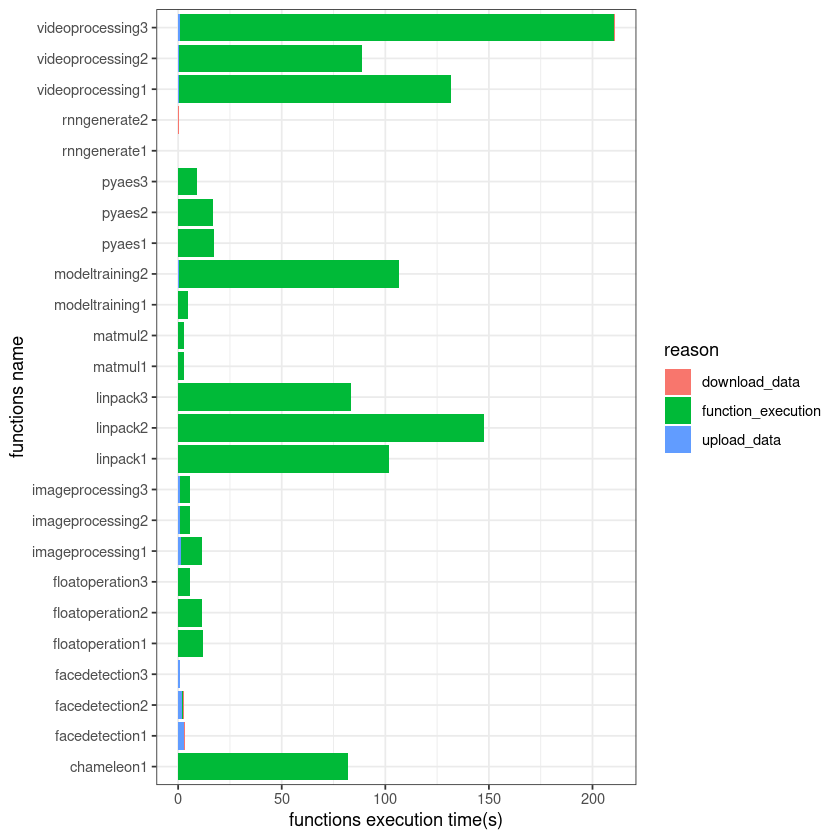

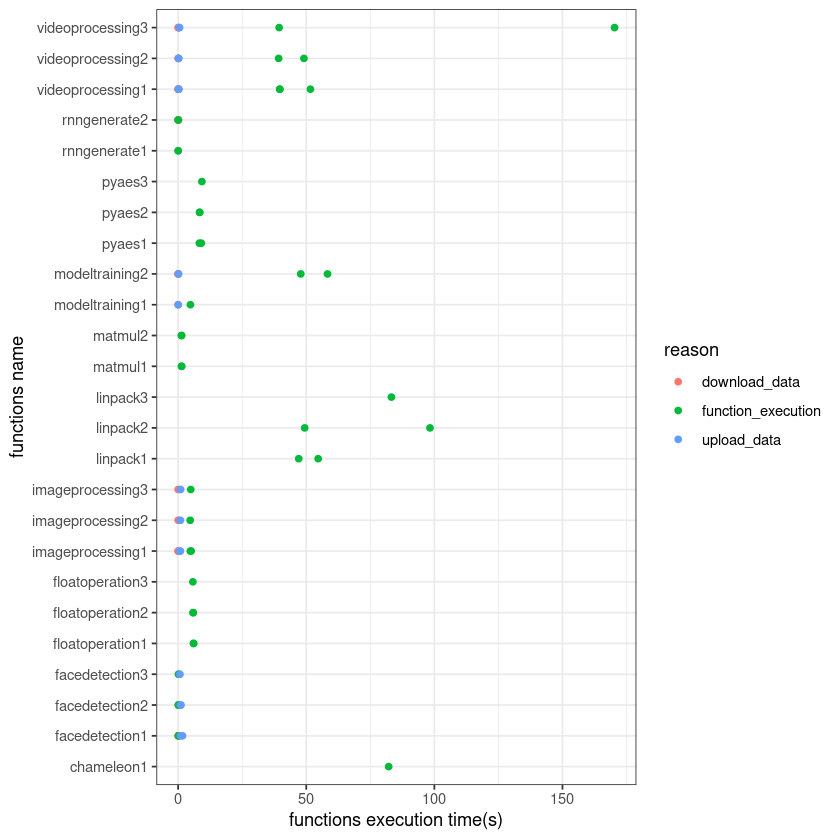

In [7]:
df_activations_selected <- df_activations %>%
    select(
        function_name,
        duration,
        reason,
        node,
        object_uid) #%>%
        #mutate(duration = (duration / 1000) %% 60)

str(df_activations_selected)
df_plot <- df_activations_selected

ggplot(data = df_plot) +
   geom_bar(aes(x = duration, y = function_name, fill = reason),stat='identity')  +
   labs(x = "functions execution time(s)", y = "functions name") +
   theme_bw() +
   ggsave('activations_bar_plot.png')

ggplot(data = df_plot) +
   geom_point(aes(x = duration, y = function_name, color = reason),stat='identity')  +
   labs(x = "functions execution time(s)", y = "functions name") +
   theme_bw() +
   ggsave('activations_point_plot.png')

In [8]:
### Spread the timestamps of activations by categories

In [9]:
head(df_activations)
df_activations_selected <- df_activations %>%
    select(
       #object_uid,
       function_name,
       duration,
       reason) #%>%
    #mutate(duration = (duration / 1000) %% 60)

df_spread_activations <- df_activations_selected %>%
   group_by_at(vars(-duration)) %>%
   mutate(sample_id = row_number()) %>% ungroup() %>%
   spread(reason, duration) %>%
   select(-sample_id)

head(df_spread_activations)
tail(df_spread_activations)

object_uid                       object_name      function_name   
1 b94c62d5c68545228c62d5c685452297 videoprocessing3 videoprocessing3
2 b94c62d5c68545228c62d5c685452297 videoprocessing3 videoprocessing3
3 b94c62d5c68545228c62d5c685452297 videoprocessing3 videoprocessing3
4 abb15066e53c4328b15066e53c732831 videoprocessing1 videoprocessing1
5 abb15066e53c4328b15066e53c732831 videoprocessing1 videoprocessing1
6 abb15066e53c4328b15066e53c732831 videoprocessing1 videoprocessing1
  duration    reason             node message
1  0.05746984 download_data      NA   NA     
2 39.41776133 function_execution NA   NA     
3  0.20162249 upload_data        NA   NA     
4  0.03561139 download_data      NA   NA     
5 39.62108564 function_execution NA   NA     
6  0.22309756 upload_data        NA   NA

function_name  download_data function_execution upload_data
1 chameleon1             NA    82.16098571               NA  
2 facedetection1 0.12681937     0.12681937        1.7097549  
3 facedetection1 0.09535384     0.09535384        0.9745057  
4 facedetection2 0.12583613     0.12583613        1.1034560  
5 facedetection2 0.16524768     0.16524768        0.9558966  
6 facedetection3 0.16789842     0.16789842        0.7206790

function_name    download_data function_execution upload_data
1 videoprocessing1 0.04237819     51.63808          0.1960278  
2 videoprocessing1 0.03778815     39.72998          0.1896362  
3 videoprocessing2 0.04656267     39.22689          0.1824017  
4 videoprocessing2 0.05358911     49.09851          0.1683929  
5 videoprocessing3 0.05746984     39.41776          0.2016225  
6 videoprocessing3 0.08218884    170.33739          0.5633061

In [10]:
### Merge the activations and events data
library(stringr)

In [11]:
df_events_to_join <- df_processed #%>% mutate(id = row_number())
head(df_events_to_join)
df_activations_to_join <- df_spread_activations #%>% mutate(id = row_number())
head(df_activations_to_join)

df_all <- full_join(
   df_events_to_join,
   df_activations_to_join,
   by="function_name") #%>%
   #distinct()
df_all[is.na(df_all)] = 0

#head(df_all)

#df_renamed <- df_all %>%
#    group_by(object_uid) %>%
#    mutate(function_name = paste(function_name, '_', substr(object_uid, 1, 4))) %>%
#    ungroup() %>%
#    select(-object_uid)
#head(df_renamed)

df_gathered <- df_all %>%
    gather(
        factor_key = 'TRUE',
        key = 'reason',
        value = 'duration',
        -function_name, -node) 
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_image_downloading', '00_container_image_downloading')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_image_creation', '01_container_image_creation')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_initialization', '02_container_initialization')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'download_data', '03_download_data')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'function_execution', '04_function_execution')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'upload_data', '05_upload_data')

df_plot <- df_gathered
head(df_plot)
tail(df_plot)
#summary(df_plot)
#str(df_plot)

function_name  node                            container_image_downloading
1 chameleon1     paravance-11.rennes.grid5000.fr NA                         
2 chameleon1     paravance-11.rennes.grid5000.fr NA                         
3 facedetection1 paravance-13.rennes.grid5000.fr NA                         
4 facedetection1 paravance-13.rennes.grid5000.fr NA                         
5 facedetection2 paravance-13.rennes.grid5000.fr NA                         
6 facedetection2 paravance-13.rennes.grid5000.fr NA                         
  container_image_creation container_initialization
1 NA                       NA                      
2 NA                       NA                      
3 NA                       NA                      
4 NA                       NA                      
5 NA                       NA                      
6 NA                       NA

function_name  download_data function_execution upload_data
1 chameleon1             NA    82.16098571               NA  
2 facedetection1 0.12681937     0.12681937        1.7097549  
3 facedetection1 0.09535384     0.09535384        0.9745057  
4 facedetection2 0.12583613     0.12583613        1.1034560  
5 facedetection2 0.16524768     0.16524768        0.9558966  
6 facedetection3 0.16789842     0.16789842        0.7206790

function_name  node                            reason                        
1 chameleon1     paravance-11.rennes.grid5000.fr 00_container_image_downloading
2 chameleon1     paravance-11.rennes.grid5000.fr 00_container_image_downloading
3 facedetection1 paravance-13.rennes.grid5000.fr 00_container_image_downloading
4 facedetection1 paravance-13.rennes.grid5000.fr 00_container_image_downloading
5 facedetection1 paravance-13.rennes.grid5000.fr 00_container_image_downloading
6 facedetection1 paravance-13.rennes.grid5000.fr 00_container_image_downloading
  duration
1 0       
2 0       
3 0       
4 0       
5 0       
6 0

function_name    node                            reason         duration 
1 videoprocessing2 paravance-13.rennes.grid5000.fr 05_upload_data 0.1824017
2 videoprocessing2 paravance-13.rennes.grid5000.fr 05_upload_data 0.1683929
3 videoprocessing3 paravance-11.rennes.grid5000.fr 05_upload_data 0.2016225
4 videoprocessing3 paravance-11.rennes.grid5000.fr 05_upload_data 0.5633061
5 videoprocessing3 paravance-13.rennes.grid5000.fr 05_upload_data 0.2016225
6 videoprocessing3 paravance-13.rennes.grid5000.fr 05_upload_data 0.5633061

In [12]:
### Plot the merged data

Saving 6.67 x 6.67 in image



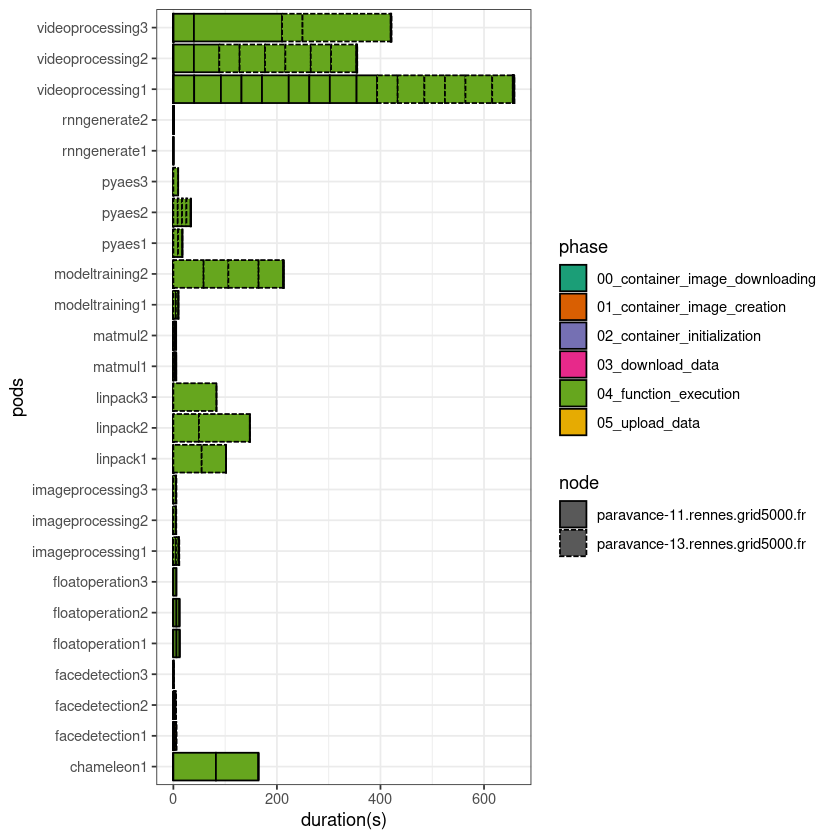

In [13]:
ggplot(data = df_plot, aes(x = duration, y = function_name, fill = reason, linetype = node))+#, color = node)) +
   geom_bar(stat='identity', position = position_stack(reverse = TRUE), color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   scale_fill_brewer(palette = "Dark2") +
   theme_bw() +
   ggsave('full_bar_plot_stack.png')

Saving 6.67 x 6.67 in image



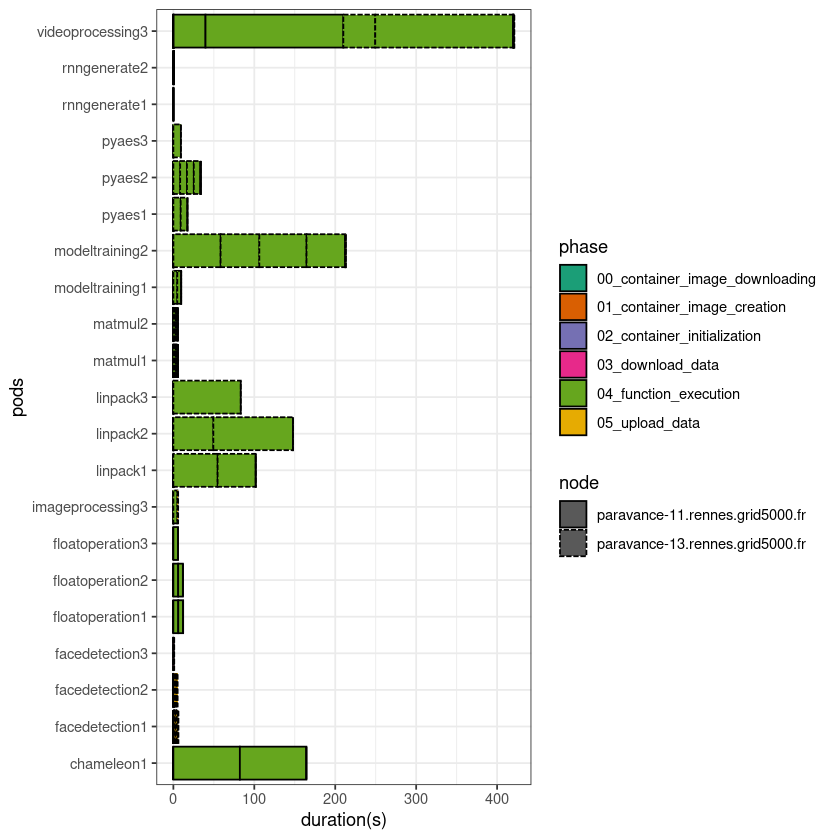

In [14]:
df_plot2 <- df_plot %>% filter(function_name != 'videoprocessing1' & function_name != 'videoprocessing2' &
                              function_name != 'imageprocessing1' & function_name != 'imageprocessing2')

ggplot(data = df_plot2, aes(x = duration, y = function_name, fill = reason, linetype = node))+#, color = node)) +
   geom_bar(stat='identity', position = position_stack(reverse = TRUE), color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   scale_fill_brewer(palette = "Dark2") +
   theme_bw() +
   ggsave('full_bar_plot_stack_filtered.png')

Saving 6.67 x 6.67 in image



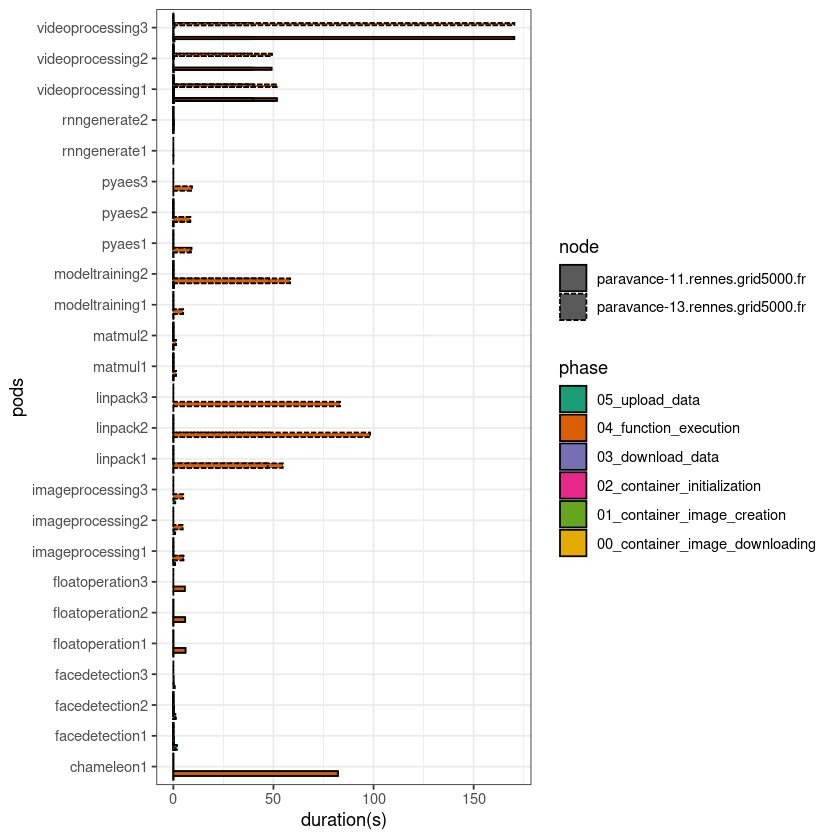

In [15]:
ggplot(data = df_plot, aes(x = duration, y = function_name, linetype = node,
                           fill = factor(reason, levels = rev(c("00_container_image_downloading",
                                  "01_container_image_creation", 
                                  "02_container_initialization", 
                                  "03_download_data", 
                                  "04_function_execution", 
                                  "05_upload_data"))))) +#, color = node)) +
   geom_bar(position="dodge", stat='identity', color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   theme_bw() +
   scale_fill_brewer(palette = "Dark2") +
   #guides(fill = guide_legend(reverse = TRUE))
   ggsave('full_bar_plot_dodge.png')

Saving 6.67 x 6.67 in image

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 303 rows containing missing values (geom_bar).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 303 rows containing missing values (geom_bar).”


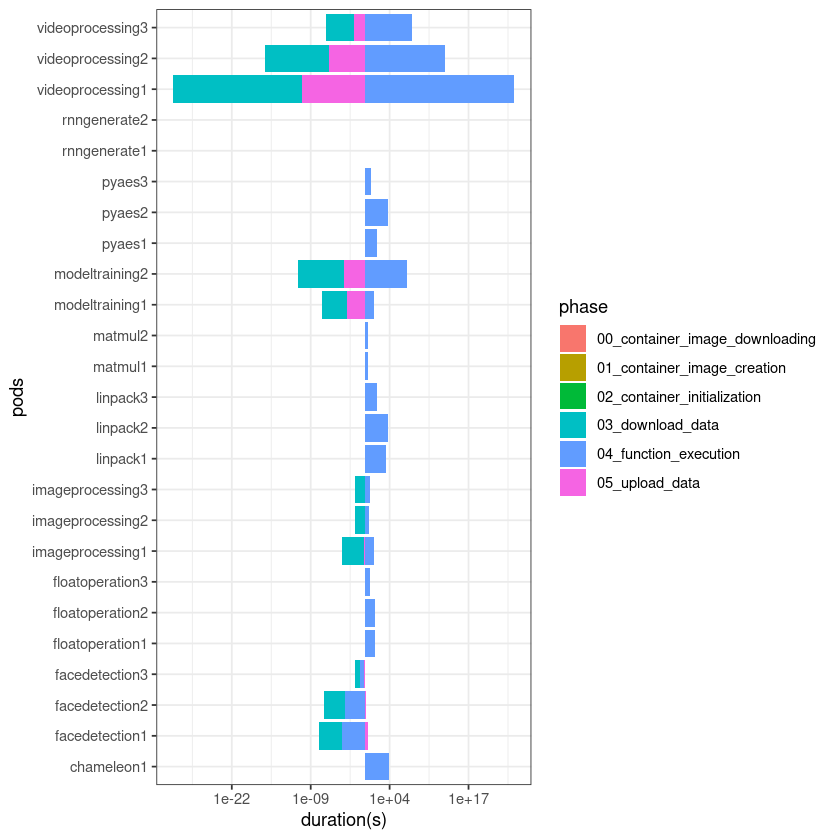

In [16]:
ggplot(data = df_plot, aes(x = duration, y = function_name, fill = reason))+#, color = node)) +
   geom_bar(stat='identity')  +
    scale_x_log10() +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   theme_bw() +
   ggsave('full_bar_plot_log10.png')

Saving 6.67 x 6.67 in image



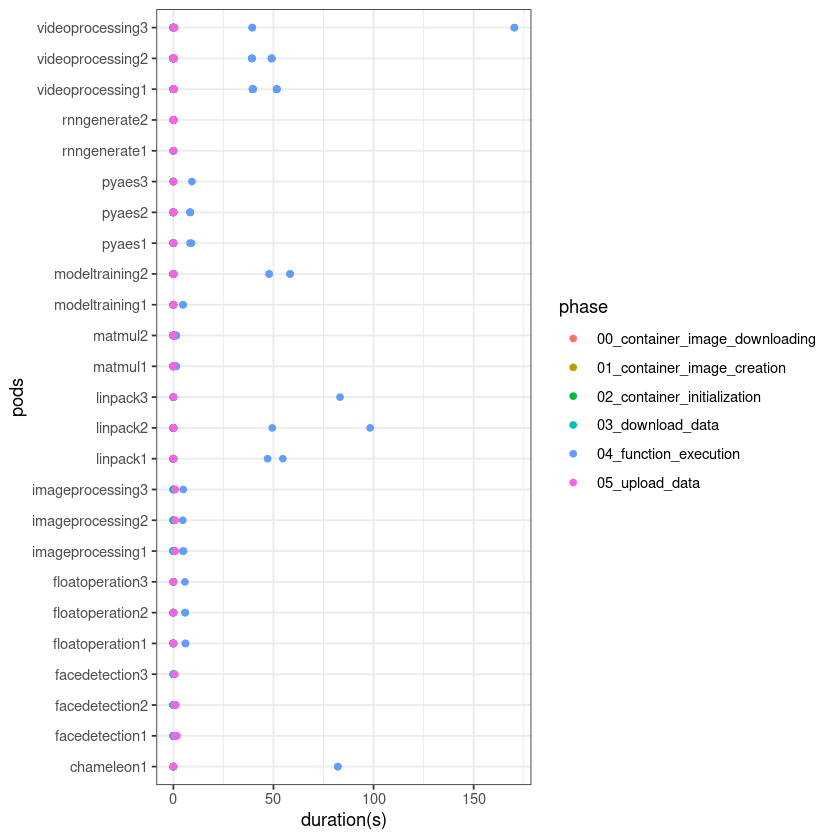

In [17]:
ggplot() +
    geom_point(data = df_plot, aes(x = duration, y = function_name, color = reason))+#, color = reason)) +
    labs(x = "duration(s)", y = "pods", color = "phase") +
    theme_bw() +
    ggsave('full_geom_point.png')

Saving 6.67 x 6.67 in image

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


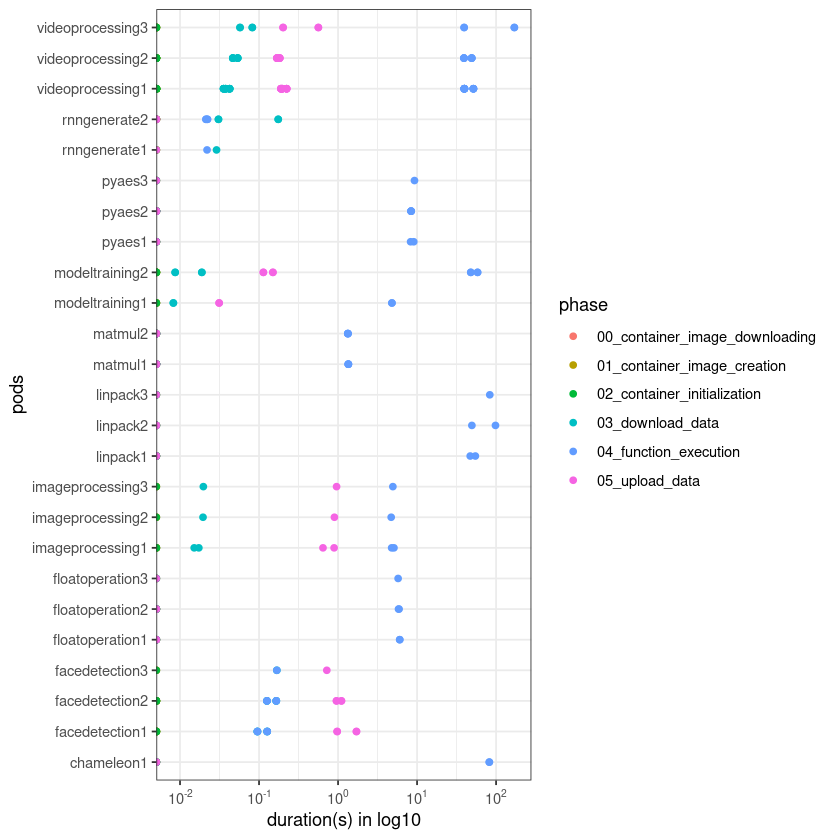

In [18]:
ggplot() +
    geom_point(data = df_plot, aes(x = duration, y = function_name, color = reason))+#, color = reason)) +
    labs(x = "duration(s) in log10", y = "pods", color = "phase") +
    scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    theme_bw() +
    ggsave('full_geom_point_log10.png')